In [53]:
import sys
sys.path.insert(0,'/home/emmanuel/Drives/erc/code/gp_autograd')
sys.path.insert(0,'/Users/eman/Documents/code_projects/gp_autograd')

# Import Kernellib 
sys.path.insert(0, '/Users/eman/Documents/code_projects/kernellib')
import numpy as np
from gp_autograd.data import example_1d
from gp_autograd.gaussianprocess import GaussianProcess, sample_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, WhiteKernel, ConstantKernel as C)
from kernellib.derivatives import ard_derivative

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
!pwd

/Users/eman/Documents/code_projects/gp_autograd/notebooks


### Sample Data

/Users/eman/anaconda3/envs/gp_autograd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


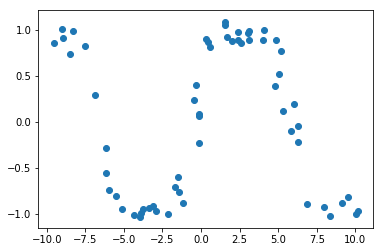

In [55]:
X, y, error_params = example_1d()

# Plot
fig, ax = plt.subplots()

ax.scatter(X['train'], y['train'])

plt.show()


## Fit GP Model

In [56]:
# Initialize GP Model
gp_model = GaussianProcess()

gp_model.fit(X['train'], y['train']);


### Predictions and Variance

#### Autograd GP

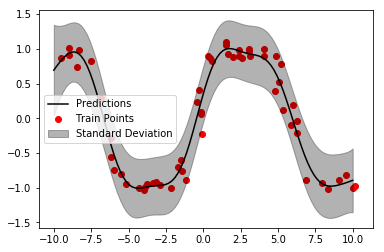

In [57]:
# Get predictions
mean, y_std = gp_model.predict(X['plot'], return_std=True)

# Plot results
fig, ax = plt.subplots()

upper_limit = mean.squeeze() + 2*y_std.squeeze()
lower_limit = mean.squeeze() - 2*y_std.squeeze()




ax.plot(X['plot'], mean, color='black', label='Predictions')
ax.scatter(X['train'], y['train'], color='red', label='Train Points')
ax.fill_between(X['plot'].squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.3, label='Standard Deviation')

ax.legend()
plt.show()


### Error Propagation

Standard Equation from Girard:

$$\mu(u, \Sigma_x) = \mu(u) + \frac{1}{2}Tr[\mu''(u)\Sigma_x]$$

I will attempt another way:

$$\mu(u, \Sigma_x) = \mu(u) + \frac{1}{2} \sqrt{\mu \Sigma_x \mu^{\top}}$$

In [44]:
SigmaX = np.diag(np.array([error_params['x']]))
SigmaX2 = np.diag(np.array([error_params['x']**2]))
print(SigmaX.shape)
mean = gp_model.predict(X['plot'])
der2_f = gp_model.mu_grad(X['plot'], nder=2)
print(SigmaX.shape, mean.shape, der_f.shape)

new_mean = mean.flatten() + 0.5 * np.sqrt(np.diag(der_f.dot(SigmaX2).dot(der_f.T))).flatten()
print(mean.shape, new_mean.shape)

(1, 1)
(1, 1) (100, 1) (100, 1)
(100, 1) (100,)


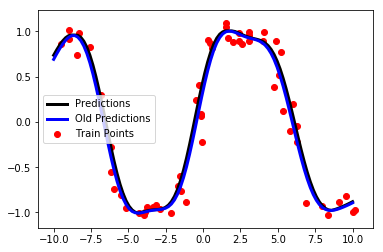

In [45]:
# Plot results
fig, ax = plt.subplots()

upper_limit = mean.squeeze() + 2*y_std.squeeze()
lower_limit = mean.squeeze() - 2*y_std.squeeze()




ax.plot(X['plot'], new_mean, color='black', linewidth=3, label='Predictions')
ax.plot(X['plot'], mean, color='blue', linewidth=3, label='Old Predictions')
ax.scatter(X['train'], y['train'], color='red', label='Train Points')


ax.legend()
plt.show()

In [51]:
std = gp_model.variance(X['plot'])

# old std
new_std = std

# first derivative of predictions
der_f = gp_model.mu_grad(X['plot'])
new_std += np.diag(der_f.dot(SigmaX).dot(der_f.T))

# 2nd derivative of the variance
der2_v = gp_model.sigma_grad(X['plot'])
new_std += np.sqrt(np.diag(der2_v.dot(SigmaX2).dot(der2_v.T)))

# 2nd Derivative of variance
new_std += std * np.sqrt(np.diag(der2_v.dot(der2_v.T)))

print(new_std.shape)

(100,)


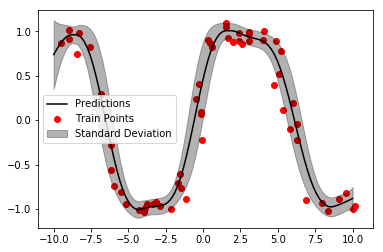

In [52]:
# Plot results
fig, ax = plt.subplots()

upper_limit = new_mean.squeeze() + 2*new_std.squeeze()
lower_limit = new_mean.squeeze() - 2*new_std.squeeze()




ax.plot(X['plot'], new_mean, color='black', label='Predictions')
ax.scatter(X['train'], y['train'], color='red', label='Train Points')
ax.fill_between(X['plot'].squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.3, label='Standard Deviation')

ax.legend()
plt.show()

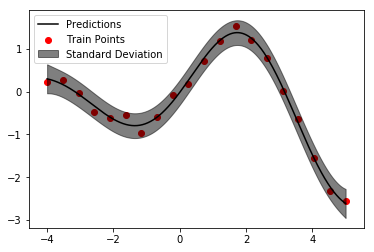

In [19]:
# Get predictions
y_pred, y_std = skgp_model.predict(xtest, return_std=True)

# Plot results
fig, ax = plt.subplots()

upper_limit = y_pred.squeeze() + 2*y_std.squeeze()
lower_limit = y_pred.squeeze() - 2*y_std.squeeze()




ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtrain, ytrain, color='red', label='Train Points')
ax.fill_between(xtest.squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.5, label='Standard Deviation')

ax.legend()
plt.show()

### 1st Derivative


#### Numerical

In [20]:
d1_numerical = mygp_model.mu_grad(xtest)          # 1st Derivative

#### Analytical

In [25]:
weights = mygp_model.weights
signal_variance = mygp_model.signal_variance
length_scale = mygp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)

np.testing.assert_array_almost_equal(d1_analytical, d1_numerical)

#### Plot

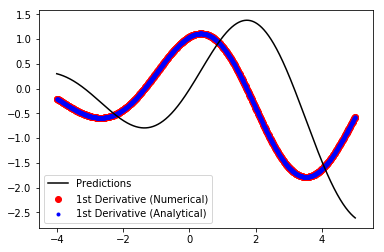

In [22]:
# Plot results
fig, ax = plt.subplots()

ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtest, d1_numerical, color='red', marker='o', label='1st Derivative (Numerical)')
ax.scatter(xtest, d1_analytical, color='blue', marker='.', label='1st Derivative (Analytical)')


ax.legend()
plt.show()

## 1st and 2nd Derivatives

In [27]:
mean_1der = mygp_model.mu_grad(xtest)          # 1st Derivative
mean_2der = mygp_model.mu_grad(xtest, nder=2)  # 2nd Derivative

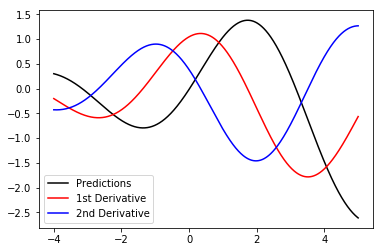

In [28]:
# Plot results
fig, ax = plt.subplots()

ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.plot(xtest, mean_1der, color='red', label='1st Derivative')
ax.plot(xtest, mean_2der, color='blue', label='2nd Derivative')

ax.legend()
plt.show()

## MultiD Example

In [29]:
from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [30]:
X, y = load_boston().data, load_boston().target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)
print(xtrain.shape, xtest.shape)

(354, 13) (152, 13)


/Users/eman/anaconda3/envs/gp_autograd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [31]:
%%time
kernel = C() * RBF(length_scale=[1.0] * X.shape[1]) + WhiteKernel()
gpr_model = GaussianProcessRegressor(kernel=kernel)
gpr_model.fit(xtrain, ytrain)
y_pred = gpr_model.predict(xtest);
mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
print(mse, mae)

18.5627545293 2.57367194297
CPU times: user 16.8 s, sys: 2.65 s, total: 19.4 s
Wall time: 10 s


In [32]:
%%time
# Initialize GP Model
gp_model = GaussianProcess()

gp_model.fit(xtrain, ytrain);

y_pred = gp_model.predict(xtest)

mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
print(mse, mae)

20.3072232014 2.38004437295
CPU times: user 1min 24s, sys: 4.67 s, total: 1min 28s
Wall time: 26.9 s


In [33]:
sk_len = gpr_model.kernel_.get_params()['k1__k2__length_scale']
my_len = gp_model.length_scale
print(sk_len)
print(my_len)

[  7.36736792e+01   1.00000000e+05   1.00000000e+05   2.76670097e+03
   4.18107140e-01   5.26296774e+00   5.68702690e+02   2.78526188e+00
   3.49362153e+02   3.94586757e+02   2.86404840e+01   2.61183205e+03
   2.24595005e+01]
[  1.04059309e+03   2.27609248e+02   5.81968793e+04   5.48048653e+03
   1.97688017e-02   2.35419642e+00   2.43449212e+02   1.83819254e+01
   4.92495387e+01   6.21434917e+02   3.42021036e+01   2.55274945e+03
   5.29686993e+01]


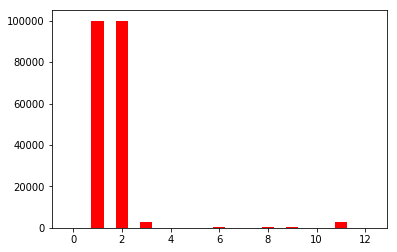

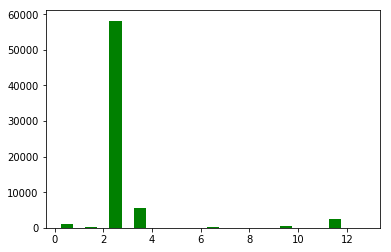

In [34]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, sk_len, width, color='r', label='Scikit GP')

plt.show()

fig, ax = plt.subplots()
gp = ax.bar(ind+width, my_len, width, color='g', label='Autograd GP')
plt.show()

### Checking the Derivatives

In [41]:
# Analytical Derivative
weights = gp_model.weights
signal_variance = gp_model.signal_variance
length_scale = gp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)

# Autograd Derivative
d1_auto = gp_model.mu_grad(xtest)          

np.testing.assert_equal(d1_auto.shape, d1_analytical.shape)
np.testing.assert_array_almost_equal(d1_analytical, d1_auto)

### Error Propagation